testperanto tutorial 3: i fought the power law, and the power law won
---------------------------------------------------------------------------------

Ultimately the goal is not to generate arbitrary strings of words, but to generate words that look "language-like". In this tutorial, we'll introduce some analytical tools for determining how "language-like" our generation is.

One useful statistic of natural language is *singleton proportion*. As we read through a text, at first we encounter many unique words, but as we continue, the proportion of new words we discover begins to diminish (since we accumulate a broader and broader vocabulary). We can visualize this phenomenon by plotting the proportion of singletons versus the number of total words seen.

In `data/europarl.en.NOUNS.100k.txt`, we provide a stream of English nouns encountered in the Europarl corpus.

1it [00:00, 14.34it/s]


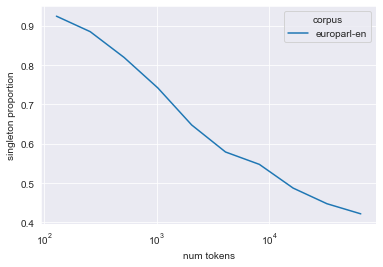

In [9]:
DATA_DIR = "../data"  # point this at the data directory in the testperanto repo
EUROPARL_EN = '{}/europarl.en.NOUN.100k.txt'.format(DATA_DIR)

%matplotlib inline
from testperanto.analysis import plot_singleton_proportion
from testperanto.util import stream_lines

corpus_labels = ['europarl-en']
streams = [stream_lines(EUROPARL_EN)]
plot_singleton_proportion(streams, corpus_labels)

Notice that (if we plot the number of words encountered on a log scale), the singleton proportion decreases more-or-less linearly, until it starts to show signs of converging. This phenomenon is surprisingly universal across languages.

Now let's generate some nouns using a version of our grammars from Tutorial 2, that uses a uniform distribution over 3000 nouns.

100%|██████████████████████████████████████████| 100000/100000 [00:13<00:00, 7408.78it/s]
2it [00:00, 19.27it/s]


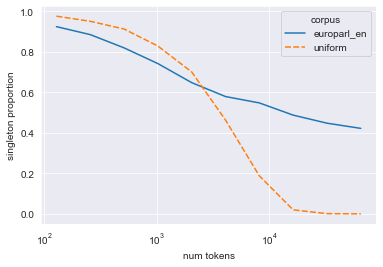

In [10]:
from testperanto.config import init_grammar_macro, generate_sentences
config = {"grammar": [
            {"rule": "START -> NN.$z1", "zdists": ["nn"]},
            {"rule": "NN.$y1 -> (@nn (STEM noun.$y1) (COUNT sng))"}
          ],
          "distributions": [
            {"name": "nn", "type": "uniform", "domain": range(3000)}
          ]}
grammar = init_grammar_macro(config)
europarl_en = stream_lines(EUROPARL_EN)
uniform = generate_sentences(grammar, start_state='START', num_to_generate=100000)
plot_singleton_proportion([europarl_en, uniform], ['europarl_en', 'uniform'])

While the percentage of singleton English nouns follows a smooth degradation, our generated nouns exhibit different behavior. There is a preliminary linear phase followed a steep plummet. This is easy to explain, because our finite set of 3000 nouns is bound to all be chosen at least twice, given enough samples.

An alternative distribution that has been observed to better emulate the statistics of natural language is the Pitman-Yor process, which has two parameters: **discount** and **strength**. It turns out that a Pitman-Yor process with discount 0.4 and strength 500 is a good match for the statistics of the Europarl corpus.

100%|██████████████████████████████████████████| 100000/100000 [00:23<00:00, 4287.57it/s]
2it [00:00, 19.22it/s]


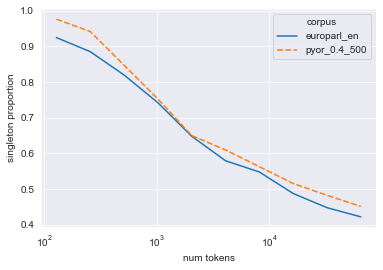

In [12]:
config = {"grammar": [
            {"rule": "START -> NN"},
            {"rule": "NN -> (@nn (STEM noun.$z1) (COUNT sng))", "zdists": ["nn"]}
          ],
          "distributions": [
            {"name": "nn", "type": "pyor", "discount": 0.4, "strength": 500.0}
          ]}
pyor__0_4__500 = generate_sentences(init_grammar_macro(config), start_state='START', num_to_generate=100000)
europarl_en = stream_lines('../data/europarl.en.NOUN.100k.txt')
plot_singleton_proportion([europarl_en, pyor__0_4__500], ['europarl_en', 'pyor_0.4_500'])

To get a sense of the impact of the two parameters, here's what happens when we vary the discount parameter:

100%|██████████████████████████████████████████| 100000/100000 [00:32<00:00, 3051.76it/s]
4it [00:00, 21.44it/s]


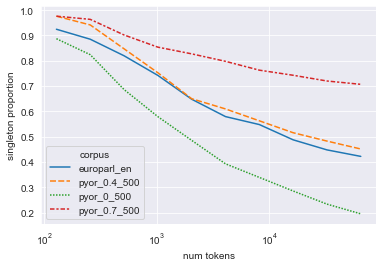

In [14]:
config['distributions'] = [{"name": "nn", "type": "pyor", "discount": 0, "strength": 500.0}]
pyor__0__500 = generate_sentences(init_grammar_macro(config), start_state='START', num_to_generate=100000)

config['distributions'] = [{"name": "nn", "type": "pyor", "discount": 0.7, "strength": 500.0}]
pyor__0_7__500 = generate_sentences(init_grammar_macro(config), start_state='START', num_to_generate=100000)

europarl_en = stream_lines('../data/europarl.en.NOUN.100k.txt')
plot_singleton_proportion([europarl_en, pyor__0_4__500, pyor__0__500, pyor__0_7__500], 
                          ['europarl_en', 'pyor_0.4_500', 'pyor_0_500', 'pyor_0.7_500'])

The discount parameter affects the asymptote to which the singleton proportion ultimately converges. Here's what happens when we vary the strength parameter:

100%|██████████████████████████████████████████| 100000/100000 [00:54<00:00, 1845.56it/s]
4it [00:00, 21.13it/s]


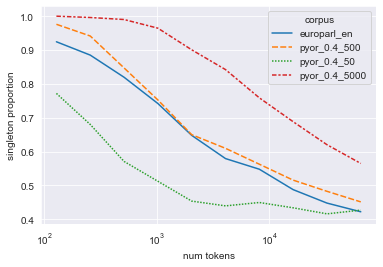

In [16]:
config['distributions'] = [{"name": "nn", "type": "pyor", "discount": 0.4, "strength": 50.0}]
pyor__0_4__50 = generate_sentences(init_grammar_macro(config), start_state='$qstart', num_to_generate=100000)

config['distributions'] = [{"name": "nn", "type": "pyor", "discount": 0.4, "strength": 5000.0}]
pyor__0_4__5000 = generate_sentences(init_grammar_macro(config), start_state='$qstart', num_to_generate=100000)

europarl_en = stream_lines('../data/europarl.en.NOUN.100k.txt')
plot_singleton_proportion([europarl_en, pyor__0_4__500, pyor__0_4__50, pyor__0_4__5000], 
                          ['europarl_en', 'pyor_0.4_500', 'pyor_0.4_50', 'pyor_0.4_5000'])

While the discount parameter affects the asymptotic limit of the singleton proportion, the strength parameter impacts the **rate** at which the curve converges to that limit.